# Script to read and process netCDF data

## Import libraries

In [15]:
import rasterio
from rasterio.features import geometry_mask
import geopandas as gpd
import xarray as xr
import rioxarray
import dask
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle

## Import shapefile and netCDF data

In [16]:
# Enable Dask's automatic parallelization
dask.config.set(scheduler='threads')

<Axes: >

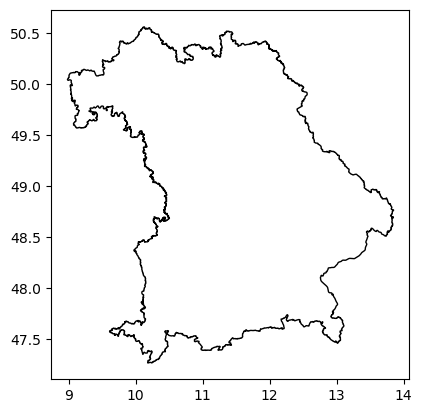

In [17]:
# Load the shapefile
shapefile_path = r"C:\Users\project\bavaria_outline.shp"
bavaria_polygon = gpd.read_file(shapefile_path)
bavaria_polygon = bavaria_polygon.to_crs('EPSG:4326')

# check the shapefile
bavaria_polygon.plot(color='white', edgecolor='black')

In [18]:
# Open the netCDF file

data = xr.open_dataset(r"J:\study_project\features\slope.nc").chunk({'variable': 10, 'lat': 1000, 'lon': 1000})

In [19]:
data['slope']

<xarray.DataArray 'slope' (variable: 4, lat: 13920, lon: 39000)> Size: 17GB
dask.array<xarray-slope, shape=(4, 13920, 39000), dtype=float64, chunksize=(4, 1000, 1000), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 111kB -56.0 -55.99 -55.98 -55.97 ... 59.98 59.99 60.0
  * lon      (lon) float64 312kB -145.0 -145.0 -145.0 ... 180.0 180.0 180.0
Dimensions without coordinates: variable
Attributes:
    COLOR_TABLE_RULE_RGB_0:   0.000000e+00 6.832000e+02 255 255 0 0 255 0
    COLOR_TABLE_RULE_RGB_1:   6.832000e+02 1.366400e+03 0 255 0 0 255 255
    COLOR_TABLE_RULE_RGB_2:   1.366400e+03 2.049600e+03 0 255 255 0 0 255
    COLOR_TABLE_RULE_RGB_3:   2.049600e+03 2.732800e+03 0 0 255 255 0 255
    COLOR_TABLE_RULE_RGB_4:   2.732800e+03 3.416000e+03 255 0 255 255 0 0
    COLOR_TABLE_RULES_COUNT:  5
    Generated_with:           GRASS GIS 7.0.0beta1
    grid_mapping:             crs
    long_name:                upstream_slope
    units:                    Degree * 100

In [20]:
# Convert the dataset to use rioxarray for geospatial operations, setting the CRS
data_rio = data.rio.write_crs("EPSG:4326")

In [21]:
# Crop the data using the region of interest, applying the shapefile's geometry
clipped_data = data_rio.rio.clip(bavaria_polygon.geometry.apply(mapping), bavaria_polygon.crs, drop=True)

In [22]:
clipped_data

<xarray.Dataset> Size: 7MB
Dimensions:  (lat: 396, lon: 584, variable: 4)
Coordinates:
  * lat      (lat) float64 3kB 47.27 47.28 47.29 47.3 ... 50.55 50.55 50.56
  * lon      (lon) float64 5kB 8.979 8.988 8.996 9.004 ... 13.82 13.83 13.84
    crs      int32 4B 0
Dimensions without coordinates: variable
Data variables:
    slope    (variable, lat, lon) float64 7MB dask.array<chunksize=(4, 396, 523), meta=np.ndarray>
Attributes:
    GDAL_AREA_OR_POINT:  Area
    Conventions:         CF-1.5
    GDAL:                GDAL 1.10.0, released 2013/04/24
    Source:              HydroSHEDS, Lehner et al. (2008)
    Dataset:             Upstream slope: minimum, maximum, range, average 
    units:               Degree * 100
    scale_factor:        100
    Author:              sami.domisch@yale.edu & giuseppe.amatulli@gmail.com
    Software:            GRASS 7 using the add-ons r.stream.watersheds & r.st...

Text(0.5, 1.0, 'Average Slope')

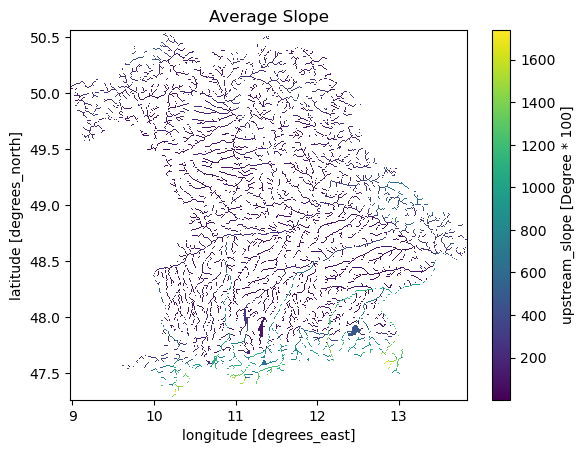

In [23]:
clipped_data['slope'][3].plot()
plt.title('Average Slope')

## Convert xarray to dataframes

In [24]:
# Flatten the data to check the dimensions required for the dataframe

flat_data = clipped_data['slope'].stack(space=['lat', 'lon'])
flat_data

<xarray.DataArray 'slope' (variable: 4, space: 231264)> Size: 7MB
dask.array<reshape, shape=(4, 231264), dtype=float64, chunksize=(4, 115632), chunktype=numpy.ndarray>
Coordinates:
    crs      int32 4B 0
  * space    (space) object 2MB MultiIndex
  * lat      (space) float64 2MB 47.27 47.27 47.27 47.27 ... 50.56 50.56 50.56
  * lon      (space) float64 2MB 8.979 8.988 8.996 9.004 ... 13.82 13.83 13.84
Dimensions without coordinates: variable
Attributes:
    COLOR_TABLE_RULE_RGB_0:   0.000000e+00 6.832000e+02 255 255 0 0 255 0
    COLOR_TABLE_RULE_RGB_1:   6.832000e+02 1.366400e+03 0 255 0 0 255 255
    COLOR_TABLE_RULE_RGB_2:   1.366400e+03 2.049600e+03 0 255 255 0 0 255
    COLOR_TABLE_RULE_RGB_3:   2.049600e+03 2.732800e+03 0 0 255 255 0 255
    COLOR_TABLE_RULE_RGB_4:   2.732800e+03 3.416000e+03 255 0 255 255 0 0
    COLOR_TABLE_RULES_COUNT:  5
    Generated_with:           GRASS GIS 7.0.0beta1
    grid_mapping:             crs
    long_name:                upstream_slope
    units:                    Degree * 100

In [25]:
# Prepare the dataframes

# Extract variable
lc_avg = clipped_data['slope']

# Convert the DataArray to a pandas DataFrame
df = lc_avg.to_dataframe(name='value').reset_index()

#pd.options.display.max_rows = 1000
#pd.options.display.min_rows = 500

# Pivot the DataFrame to have bands as columns
df_pivoted = df.pivot(index=['lat', 'lon'], columns='variable', values='value').reset_index()
display(df_pivoted)
df_pivoted.drop(df_pivoted.columns[2:5], axis=1, inplace = True)
display(df_pivoted)

#remove nan values
df_filtered = df_pivoted.dropna(axis=0, how='any').reset_index()


display(df_filtered)


variable,lat,lon,0,1,2,3
0,47.270833,8.979167,NaN,NaN,NaN,NaN
1,47.270833,8.987500,NaN,NaN,NaN,NaN
2,47.270833,8.995833,NaN,NaN,NaN,NaN
3,47.270833,9.004167,NaN,NaN,NaN,NaN
4,47.270833,9.012500,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...
231259,50.562500,13.804167,NaN,NaN,NaN,NaN
231260,50.562500,13.812500,NaN,NaN,NaN,NaN
231261,50.562500,13.820833,NaN,NaN,NaN,NaN
231262,50.562500,13.829167,NaN,NaN,NaN,NaN


variable,lat,lon,3
0,47.270833,8.979167,NaN
1,47.270833,8.987500,NaN
2,47.270833,8.995833,NaN
3,47.270833,9.004167,NaN
4,47.270833,9.012500,NaN
...,...,...,...
231259,50.562500,13.804167,NaN
231260,50.562500,13.812500,NaN
231261,50.562500,13.820833,NaN
231262,50.562500,13.829167,NaN


variable,index,lat,lon,3
0,1902,47.295833,10.229167,1423.0
1,2487,47.304167,10.237500,1436.0
2,2488,47.304167,10.245833,1463.0
3,3073,47.312500,10.254167,1493.0
4,3074,47.312500,10.262500,1532.0
...,...,...,...,...
16445,228480,50.529167,10.112500,350.0
16446,228481,50.529167,10.120833,370.0
16447,228482,50.529167,10.129167,373.0
16448,228484,50.529167,10.145833,366.0


In [26]:
# save the filtered dataframe
filepath = "df_filtered_slope"
with open(filepath, 'wb') as file:
    pickle.dump(df_filtered, file)